In [1]:
import tensorflow as tf

### Configuration
create_dataset = False

def in_google_colab():
    """Checks if the code is running in Google Colab

    Returns:
        bool: _description_
    """
    try:
        import google.colab
        return True
    except ImportError:
        return False

if in_google_colab():
    print("Running in Google Colab")
    # Install necessary packages in Google Colab
    !rm -r sample_data/
    !git clone https://github.com/naderinho/anesthesia_anomaly_detection
    !cp -r anesthesia_anomaly_detection/* .
    !rm -r anesthesia_anomaly_detection/
    !pip install vitaldb
    create_dataset = False
else:
    print("Running locally")

### Datasetpath
directory = 'data/'
datasetpath = 'dataset02/'
vitaldbpath = 'vitaldb_tiva/'

### Import the necessary libraries
import numpy as np
import pandas as pd
import vitaldb as vf
import matplotlib.pyplot as plt

### Custom functions
import modules as md

Running locally


In [2]:
###### Create Dataset
if create_dataset:
    bis = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
    bis.name = 'Bispektralindex'
    bis.tracks = ['BIS/BIS']
    bis.filter = [20, 10, 100]
    bis.generateDataset(normalization=md.NormNone)
    bis.save('00_bis.npz')

    info = md.infoImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
    info.generateDataset(normalization=md.NormStandard)
    info.save('01_info.npz')

    bloodpressure = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
    bloodpressure.name = 'bloodpressure'
    bloodpressure.tracks = ['Solar8000/ART_DBP', 'Solar8000/ART_MBP', 'Solar8000/ART_SBP']
    bloodpressure.filter = [20, 20, 250]
    bloodpressure.generateDataset(normalization=md.NormStandard)
    bloodpressure.save('02_bloodpressure.npz')

    etCO2 = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
    etCO2.name = 'End Tidal CO2'
    etCO2.tracks = ['Primus/ETCO2']
    etCO2.filter = [5, 15, 50]
    etCO2.generateDataset(normalization=md.NormStandard)
    etCO2.save('02_etCO2.npz')

    spO2 = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
    spO2.name = 'SpO2'
    spO2.tracks = ['Solar8000/PLETH_SPO2']
    spO2.filter = [3, 80, 100]
    spO2.generateDataset(normalization=md.NormStandard)
    spO2.save('02_spO2.npz')

    hr = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
    hr.name = 'Heart Rate'
    hr.tracks = ['Solar8000/HR']
    hr.filter = [20, 40, 180]
    hr.generateDataset(normalization=md.NormStandard)
    hr.save('02_hr.npz')

    propofolrate = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
    propofolrate.name = 'Propofol Rate'
    propofolrate.tracks = ['Orchestra/PPF20_RATE']
    propofolrate.filterON = False
    propofolrate.generateDataset(normalization=md.NormNone)
    propofolrate.save('03_propofol_rate.npz')

    propofolvol = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
    propofolvol.name = 'Propofol Volume'
    propofolvol.tracks = ['Orchestra/PPF20_VOL']
    propofolvol.filterON = False
    propofolvol.filter = [2, 0, 500]
    propofolvol.generateDataset(normalization=md.NormNone)
    propofolvol.save('03_propofol_vol.npz')

### Load the datasets
bis = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
bis.load('00_bis.npz')

info = md.infoImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
info.load('01_info.npz')

bloodpressure = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
bloodpressure.load('02_bloodpressure.npz')

etCO2 = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
etCO2.load('02_etCO2.npz')

spO2 = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
spO2.load('02_spO2.npz')

hr = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
hr.load('02_hr.npz')

propofolrate = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
propofolrate.load('03_propofol_rate.npz')

propofolvol = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
propofolvol.load('03_propofol_vol.npz')

train_index, val_index, test_index = bis.split(np.array(bis.index))

In [3]:
########################################## COMBINED MODEL ##########################################
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, LSTM, Dense, ReLU, Dropout, Concatenate, Masking, Conv1D, MaxPooling1D, BatchNormalization, RepeatVector, Lambda
from tensorflow.keras.metrics import RootMeanSquaredError, MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError

### LSTM layers for the blood pressure data

### Combine the vital data
vital_train = np.concatenate([bloodpressure.train_dataset, etCO2.train_dataset, spO2.train_dataset, hr.train_dataset], axis=2)
vital_validation = np.concatenate([bloodpressure.validation_dataset, etCO2.validation_dataset, spO2.validation_dataset, hr.validation_dataset], axis=2)
vital_test = np.concatenate([bloodpressure.test_dataset, etCO2.test_dataset, spO2.test_dataset, hr.test_dataset], axis=2)

### LSTM layers for the vital data
input_vital = Input(shape=(None, vital_train.shape[2]))
vital_layer = Masking(mask_value=0.0)(input_vital)

### INFO layers
input_info = Input(shape=(info.train_dataset.shape[1],))
info_layer = RepeatVector(vital_train.shape[1])(input_info)

## Concatenate the LSTM output with the info layer
comb_layer = Concatenate()([vital_layer, info_layer])
#comb_layer = LSTM(units=32, return_sequences=True)(comb_layer)
#comb_layer = BatchNormalization()(comb_layer)
#comb_layer = LSTM(units=32, return_sequences=True)(comb_layer)
#comb_layer = BatchNormalization()(comb_layer)
#comb_layer = LSTM(units=32, return_sequences=True)(comb_layer)
#comb_layer = BatchNormalization()(comb_layer)
#comb_layer = Dense(units=128, activation='relu')(comb_layer)
#comb_layer = BatchNormalization()(comb_layer)
comb_layer = Dense(units=32, activation='relu')(comb_layer)
comb_layer = BatchNormalization()(comb_layer)


output = Dense(units=1, activation='sigmoid')(comb_layer)
output = Lambda(lambda x: x * 100)(output)

# Define the model
model = Model(inputs=[input_vital, input_info], outputs=output)

# Compile the model
optimizer = Adam(learning_rate=0.01)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['MeanSquaredError','MeanAbsoluteError','RootMeanSquaredError']
              )

#model.summary()
y = pd.DataFrame(bis.train_dataset[:,:,0].T).rolling(min_periods=1,window=20, center=True).mean().to_numpy().T[:,:,np.newaxis]

# Train the model
history = model.fit([vital_train, info.train_dataset],
                    y,
                    validation_data=([vital_validation, info.validation_dataset], bis.validation_dataset),
                    epochs=30,
                    batch_size=4
                    )

train_score = history.history

Epoch 1/30
28/28 [==============================] - 1s 9ms/step - loss: 289.9210 - mean_squared_error: 289.9210 - mean_absolute_error: 10.8565 - root_mean_squared_error: 17.0271 - val_loss: 1760.5492 - val_mean_squared_error: 1760.5491 - val_mean_absolute_error: 40.5834 - val_root_mean_squared_error: 41.9589
Epoch 2/30
28/28 [==============================] - 0s 6ms/step - loss: 145.6609 - mean_squared_error: 145.6609 - mean_absolute_error: 8.4842 - root_mean_squared_error: 12.0690 - val_loss: 1327.5076 - val_mean_squared_error: 1327.5076 - val_mean_absolute_error: 34.9792 - val_root_mean_squared_error: 36.4350
Epoch 3/30
28/28 [==============================] - 0s 6ms/step - loss: 114.5857 - mean_squared_error: 114.5857 - mean_absolute_error: 7.6768 - root_mean_squared_error: 10.7045 - val_loss: 820.3794 - val_mean_squared_error: 820.3793 - val_mean_absolute_error: 27.1994 - val_root_mean_squared_error: 28.6423
Epoch 4/30
28/28 [==============================] - 0s 6ms/step - loss: 10

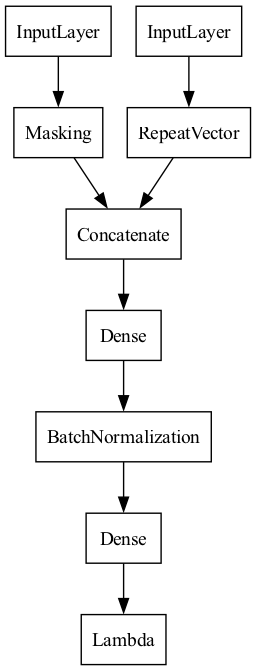

In [12]:
from tensorflow.keras.utils import plot_model

plot_model(model,
    show_shapes=False,
    show_dtype=False,
    show_layer_names=False,
    #rankdir="TB",
    expand_nested=False,
    dpi=100,
    show_layer_activations=False,
    show_trainable=False
    )

# Training results

In [ ]:
from utils.plotting import training_loss_plot

### Training Summary
plot = training_loss_plot(train_score)
plot.show()

# Testing

In [ ]:
### Predict on the test set
from utils.evaluation import phases_report

y_pred =  model.predict([vital_test, info.test_dataset], verbose=0)

phases_report(y_pred, bis.test_dataset, propofolrate.test_dataset)

In [ ]:
from utils.evaluation import correlation

test_correlation, baseline_correlation = correlation(bis.test_dataset, y_pred)

In [ ]:
from utils.plotting import single_prediction_plot

plot = single_prediction_plot(5, test_index, bis.test_dataset, y_pred)
plot.show()

In [ ]:
from utils.plotting import full_prediction_plot

full_prediction_plot(test_index, bis.test_dataset, y_pred)